In [1]:
import os
import pickle
import numpy as np
import datetime
import json
from multiprocessing import Process
from multiprocess import Process

import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16, MobileNetV2, MobileNetV3Small

from models import *
from utils import regression_stats
from img_utils import data_to_df, preprocess_images, set_gpu, set_cpu

import matplotlib.pyplot as plt

2024-04-25 14:25:02.679344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 14:25:02.679401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 14:25:02.680533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 14:25:02.686643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 14:25:04.176700: W tensorflow/compiler/tf2

In [2]:
from img_utils import data_to_df
#try reloading the module
IMAGE_WIDTH: int = 224
IMAGE_HEIGHT: int = 224


# Load Data
train_1_path: str = "../nybolig-scrape/output/train/train_1"
train_2_path: str = "../nybolig-scrape/output/train/train_2"
valid_path: str = "../nybolig-scrape/output/valid"
test_path: str = "../nybolig-scrape/output/test"


# train_1_path: str = "output/train/train_1"
# train_2_path: str = "output/train/train_2"
# valid_path: str = "output/valid"
# test_path: str = "output/test"

train1_df, train2_df, valid_df, test_df = data_to_df(
    [train_1_path, train_2_path, valid_path, test_path], preprocess=True
)

display(train1_df.head())
# Print the lenghts of the datasets
print("Length of datasets:")
print(f"Train 1: {len(train1_df)}")
print(f"Train 2: {len(train2_df)}")
print(f"Valid: {len(valid_df)}")
print(f"Test: {len(test_df)}")

# TODO: Would be better with this format
# train_images: np.array = preprocess_images(
#     train1_df["image_floorplan"], IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
# )


#### Train Set 1 ####
train1_features = train1_df.drop(columns=["image_floorplan", "price"])
train1_images: np.array = preprocess_images(
    train1_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
train1_prices: np.array = train1_df["price"].values


#### Train Set 2 ####
train2_features = train2_df.drop(columns=["image_floorplan", "price"])
train2_images: np.array = preprocess_images(
    train2_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
train2_prices: np.array = train2_df["price"].values


#### Validation Set ####
valid_features = valid_df.drop(columns=["image_floorplan", "price"])
valid_images: np.array = preprocess_images(
    valid_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
valid_prices: np.array = valid_df["price"].values


#### Test Set ####
test_features = test_df.drop(columns=["image_floorplan", "price"])
test_images: np.array = preprocess_images(
    test_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
test_prices: np.array = test_df["price"].values

Processing ../nybolig-scrape/output/train/train_1: 100%|██████████| 311/311 [00:00<00:00, 1489073.68it/s]
Processing ../nybolig-scrape/output/train/train_2: 100%|██████████| 312/312 [00:00<00:00, 1595881.52it/s]
Preprocessing: 100%|██████████| 4/4 [00:00<00:00, 226.35it/s]


,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,postal_avg_sqm_price,lat,lng,image_floorplan
0,47,0,2725000,66,0,3,1934.0,1934.0,4,33507.5,55.696548,12.500334,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,33,0,3195000,51,0,2,1886.0,1886.0,5,51502.5,55.691847,12.559937,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,46,0,1875000,61,0,2,1975.0,1975.0,5,0.0,56.130894,9.157316,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,46,0,1795000,61,0,2,1975.0,1975.0,5,0.0,56.130894,9.157316,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,46,0,3350000,104,0,3,1975.0,1975.0,5,0.0,56.130894,9.157316,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


Length of datasets:
Train 1: 289
Train 2: 292
Valid: 86
Test: 162


In [3]:
def save_expected_predicted(test_prices, test_predictions, img_dir):
        #Set X and Y axis to [0, 9.000.000]
    #plt.xlim(0, 9999999)
    #plt.ylim(0, 9999999)
    plt.scatter(test_prices, test_predictions)
    plt.xlabel("Expected Price")
    plt.ylabel("Predicted Price")
    plt.title("Expected vs Predicted Price")
    try: 
        plt.plot([min(test_prices), max(test_prices)], [min(test_prices), max(test_prices)], color='red')
    except:
        pass
    plt.savefig(f"{img_dir}/expected_vs_predicted.png")
    plt.close()

def save_residuals(test_prices, test_predictions, img_dir):
    residuals = test_prices - test_predictions.reshape(-1)
    plt.scatter(test_predictions, residuals)
    try:
        plt.hlines(y=0, xmin=test_prices.min(), xmax=test_prices.max(), colors="r")
    except:
        pass
    plt.xlabel("Expected Price")
    plt.ylabel("Residuals")
    plt.title("Residuals")
    plt.savefig(f"{img_dir}/residuals.png")
    plt.close()

def get_saliency_map(model, image):
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    image = image.astype(np.float32)
    image = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
    gradients = tape.gradient(prediction, image)
    gradients = tf.squeeze(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy()
    gradients = (gradients - np.min(gradients)) / (np.max(gradients) - np.min(gradients))
    return gradients

def save_worst_best_predictions(model, test_predictions, test_prices, test_images, img_dir):
    residuals = test_prices - test_predictions.reshape(-1)
    distances = np.abs(test_prices - test_predictions.reshape(-1))
    worst_predictions = np.argsort(distances)[-8:]
    best_predictions = np.argsort(distances)[:8]
    test_images = np.array(test_images)
    for i, idx in enumerate(worst_predictions):
        image = test_images[idx]
        price = test_prices[idx]
        prediction = test_predictions[idx]
        residual = residuals[idx]
        plt.imshow(image)
        textstr = '\n'.join((
            f"Price: {price}",
            f"Predicted Price: {prediction}",
            f"Residual: {residual}"
        ))
        plt.text(0.01, 0.99, textstr, fontsize=10, transform=plt.gcf().transFigure, verticalalignment='top')
        plt.axis("off")
        plt.savefig(f"{img_dir}/worst_{i}.png")
        plt.close()
        
        saliency_map = get_saliency_map(model, image)
        plt.imshow(saliency_map, cmap="hot")
        plt.axis("off")
        plt.savefig(f"{img_dir}/worst_saliency_map_{i}.png")
        plt.close()
        
    for i, idx in enumerate(best_predictions):
        image = test_images[idx]
        price = test_prices[idx]
        prediction = test_predictions[idx]
        residual = residuals[idx]
        plt.imshow(image)
        textstr = '\n'.join((
            f"Price: {price}",
            f"Predicted Price: {prediction}",
            f"Residual: {residual}"
        ))
        plt.text(0.01, 0.99, textstr, fontsize=10, transform=plt.gcf().transFigure, verticalalignment='top')
        plt.axis("off")
        plt.savefig(f"{img_dir}/best_{i}.png")
        plt.close()
        saliency_map = get_saliency_map(model, image)
        plt.imshow(saliency_map, cmap="hot")
        plt.axis("off")
        plt.savefig(f"{img_dir}/best_saliency_map_{i}.png")
        plt.close()

def save_features_importance(feature_importance, img_dir):
    #sort the feature_importance dict by value
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
    #add percentages to the bars
    plt.bar(feature_importance.keys(), feature_importance.values())
    #plt.bar_label = feature_importance.values()
    plt.title('Feature Importance')
    #Remove y-labels
    plt.ylabel('')
    plt.xticks(rotation=90)
    #Zoom out so that text is visible 
    plt.subplots_adjust(bottom=0.4)
    plt.savefig(f"{img_dir}/feature_importance.png")
    plt.close()

def save_worst_best(test_predictions, test_prices, test_features, model_dir):
    #Find the best predictions, and worst predictions. 
    #Save them in two dataframes. Save a latex of the dataframe in a txt-file 
    residuals = test_prices - test_predictions.reshape(-1)
    distances = np.abs(test_prices - test_predictions.reshape(-1))
    worst_predictions = np.argsort(distances)[-8:]
    best_predictions = np.argsort(distances)[:8]
    
    test_features_ = pd.DataFrame(test_features).copy()
    test_features_["Price"] = test_prices
    test_features_["Predicted Price"] = test_predictions
    test_features_["Residual"] = residuals
    test_features_ = test_features_.sort_values(by="Residual", ascending=False)
    worst_df = test_features_.iloc[worst_predictions]
    best_df = test_features_.iloc[best_predictions]
    #save worst and best as latex in txt-file 
    worst_df.to_latex(f"{model_dir}/worst_predictions.txt")
    best_df.to_latex(f"{model_dir}/best_predictions.txt")
    
def get_reconstructions(CNN_AE_RF_model, test_predictions, test_prices, test_images, img_dir):
    residuals = test_prices - test_predictions.reshape(-1)
    residuals = test_prices - test_predictions.reshape(-1)
    distances = np.abs(test_prices - test_predictions.reshape(-1))
    worst_predictions = np.argsort(distances)[-8:]
    best_predictions = np.argsort(distances)[:8]
    for i in range(8):
        idx = best_predictions[i]
        image = test_images[idx]
        price = test_prices[idx]
        prediction = test_predictions[idx]
        residual = residuals[idx]
        encoded_img, decoded_img = CNN_AE_RF_model.get_reconstruction(np.expand_dims(image, axis=0))
        plt.imshow(tf.squeeze(decoded_img))
        plt.show()
        

    # for i in range(8):
    #     idx = best_predictions[i]
    #     image = test_images[idx]
    #     price = test_prices[idx]
    #     prediction = test_predictions[idx]
    #     residual = residuals[idx]
    #     encoded_img, decoded_img = CNN_AE_RF_model.get_reconstruction(np.expand_dims(image, axis=0))
        


    


def save_model_and_evaluate(
    model: object,
    fit_history: object,
    test_images: np.array,
    test_features: np.array,
    test_prices: np.array,
    model_dir: str,
    model_type:str
):
    if model_type == 'RF':
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        with open(f"{model_dir}/model", "wb") as file_pi:
            pickle.dump(model, file_pi)
        test_predictions = model.predict(test_features)
    
    if model_type == "CNN":
        # Save Model
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model.save(f"{model_dir}/model")
        # Save Training History
        with open(f"{model_dir}/history", "wb") as file_pi:
            pickle.dump(fit_history.history, file_pi)
        test_predictions = model.predict(test_images)
        #Save Model Architecture
        #plot_model(model, to_file=f"{model_dir}/model_architecture.png", show_shapes=True, show_layer_names=True, show_dtype=True, rankdir="TB", expand_nested=False, dpi=96)
        img = plot_model(model, to_file=f"{model_dir}/architecture.png", show_shapes=True, show_layer_names=True, show_dtype=True, rankdir="TB", expand_nested=False, dpi=96)


    if model_type == 'CNN_RF' or model_type == 'CNN_AE_RF':
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        with open(f"{model_dir}/model", "wb") as file_pi:
            pickle.dump(model, file_pi)
        test_predictions = model.predict(test_images, test_features)
        

    # Evaluate Model
    print("Evaluating Model...")
    r2, mae, percentage_error, mse = regression_stats(test_prices, test_predictions)

    try:
        feature_importance = model.feature_importances_
        if model_type == "RF":
            feature_importance = dict(zip(test_features.columns, feature_importance))
    except AttributeError:
        print("Cant find feature_importance")
        feature_importance = None

    # Load existing evaluation data
    evaluation_file_path = f"{model_dir}/evaluation.json"
    evaluation_data = {}
    if os.path.exists(evaluation_file_path):
        with open(evaluation_file_path, "r") as json_file:
            evaluation_data = json.load(json_file)

    # Add new evaluation data
    new_evaluation = {
        "Timestamp": str(datetime.datetime.now()),
        "R2": r2,
        "MAE": mae,
        "Percentage Error": percentage_error,
        "MSE": mse,
        "Feature Importances": (feature_importance),
    }
    evaluation_data[len(evaluation_data)] = new_evaluation

    # Save updated evaluation data
    with open(evaluation_file_path, "w") as json_file:
        json.dump(evaluation_data, json_file, indent=4)

    # Compute median evaluation values from all instances
    r2_values = [evaluation_data[key]["R2"] for key in evaluation_data]
    mae_values = [evaluation_data[key]["MAE"] for key in evaluation_data]
    percentage_error_values = [
        evaluation_data[key]["Percentage Error"] for key in evaluation_data
    ]
    mse_values = [evaluation_data[key]["MSE"] for key in evaluation_data]

    median_evaluation_data = {
        "R2": np.median(r2_values),
        "MAE": np.median(mae_values),
        "Percentage Error": np.median(percentage_error_values),
        "MSE": np.median(mse_values),
    }

    with open(f"{model_dir}/median_evaluation.json", "w") as json_file:
        json.dump(median_evaluation_data, json_file, indent=4)

    print("\nModel Evaluation:")
    print(new_evaluation)
    print("\nMedian Evaluation:")
    print(median_evaluation_data)
    print("Feauter Importance...")
    print(feature_importance)

    # Images (Create or open existing folder)
    if not os.path.exists(f"{model_dir}/images"):
        os.makedirs(f"{model_dir}/images")
    img_dir = f"{model_dir}/images"
    
    save_expected_predicted(test_prices, test_predictions, img_dir)
    save_residuals(test_prices, test_predictions, img_dir)
    
    if model_type == 'CNN':
        print("\nSaving Best and Worst Image Predictions")
        save_worst_best_predictions(model, test_predictions, test_prices, test_images, img_dir)
    
    if model_type != 'CNN': 
        print("\nSaving Feature Importance")
        save_features_importance(feature_importance, img_dir)

    save_worst_best(test_predictions, test_prices, test_features, model_dir)
    print("\nDone!")

    if model_type == 'CNN_AE_RF':
        print("\nSaving Reconstructions")
        get_reconstructions(model, test_predictions, test_prices, test_images, img_dir)


def train_save_model(
    model_func: object,
    args: tuple,
    test_images: np.array,
    test_features: np.array,
    test_prices: np.array,
    model_dir: str,
    use_gpu: bool,
    model_type:str
):
    
    if use_gpu:
        set_gpu()
    else:
        set_cpu()

    if model_type == "CNN":
        model, fit_history = model_func(*args)
    if model_type == 'RF':
        model = model_func(*args)
        fit_history = None
    if model_type == 'CNN_RF' or model_type == 'CNN_AE_RF':
        model = model_func(*args)
        fit_history = None
    save_model_and_evaluate(model, fit_history, test_images, test_features, test_prices, model_dir, model_type)


def train_save_models(
    model_func: object,
    args: tuple,
    test_images: np.array,
    test_prices: np.array,
    model_dir: str,
    use_gpu: bool,
):
    if use_gpu:
        set_gpu()
    else:
        set_cpu()

    models, fit_histories = model_func(*args)
    for model_idx, (model, fit_history) in enumerate(zip(models, fit_histories)):
        save_model_and_evaluate(
            model, fit_history, test_images, test_prices, f"{model_dir}_{model_idx}"
        )

# Running on GPU

In [5]:
MODELS_PATH: str = "./models"
USE_GPU: bool = True

# TYPE = "RF"
# MODEL_NAME: str = "RF"
# FUNCTION: object = RF
# ARGS: tuple = (
#     train_images,
#     train_prices,
#     valid_images,
#     valid_prices,
# )
# p = Process(
#     target=train_save_model,
#     args=(FUNCTION, ARGS, test_images, test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU),
# )


# TYPE = "CNN"
# MODEL_NAME: str = "VGG16"
# FUNCTION: object = CNN_model
# ARGS: tuple = (
#     VGG16,
#     train1_images,
#     train1_prices,
#     valid_images,
#     valid_prices,
#     [
#         Flatten(),
#         Dense(512, activation="relu"),
#         BatchNormalization(),
#         Dropout(0.5),
#         Dense(256, activation="relu"),
#         BatchNormalization(),
#         Dropout(0.5),
#         Dense(1),
#     ],
# )


# TODO: Whenever this is uncommented, "CUDA_ERROR_NOT_INITIALIZED" is thrown
TYPE = "CNN_RF"
MODEL_NAME: str = "EfficientNetB3_RF"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    f"{MODELS_PATH}/EfficientNetB3/model",
    None,
    train2_images,
    train2_features,
    train2_prices,
)

# from models import CNN_AE_RF_model
# img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
# TYPE = 'CNN_RF'
# MODEL_NAME: str = "MobileNetV2_AE_RF"
# FUNCTION: object = CNN_AE_RF_model
# ARGS: tuple = (
#      # keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model") #Load the model that is trained above (e.g. vgg16)
#     train2_images,
#     train2_features,
#     train2_prices,
# )
# p = Process(
#     target=train_save_models,
#     args=(FUNCTION, ARGS, test_images, test_prices, f"{MODELS_PATH}/{MODEL_NAME}"),
# )


# TYPE = 'CNN_RF'
# MODEL_NAME: str = "N_CNN_MobileNetV2_RF"
# FUNCTION: object = N_CNN_RF_model
# ARGS: tuple = (
#     2,
#     MobileNetV3Small,
#     np.concatenate((train1_images, train2_images), axis=0),
#     pd.concat((train1_features, train2_features), axis=0),

#     np.concatenate((train1_prices, train2_prices), axis=0),
# )
# p = Process(
#     target=train_save_models,
#     args=(FUNCTION, ARGS, test_images, test_prices, f"{MODELS_PATH}/{MODEL_NAME}"),
# )


# TYPE = "N_CNN"
# MODEL_NAME: str = "N_CNN_MobileNetV2"
# FUNCTION: object = N_CNN_model
# ARGS: tuple = (
#     MobileNetV2,
#     train_images,
#     train_prices,
#     valid_images,
#     valid_prices,
#     3,
# )
# p = Process(
#     target=train_save_models,
#     args=(FUNCTION, ARGS, test_images, test_prices, f"{MODELS_PATH}/{MODEL_NAME}"),
# )


p = Process(
    target=train_save_model,
    args=(
        FUNCTION,
        ARGS,
        test_images,
        test_features,
        test_prices,
        f"{MODELS_PATH}/{MODEL_NAME}",
        USE_GPU,
        TYPE,
    ),
)
p.start()
p.join()

2024-04-25 14:39:22.850831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 14:39:23.115245: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 14:39:23.115341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 14:39:23.121697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 14:39:23.121848: I external/local_xla/xla/stream_executor

1 Physical GPUs, 1 Logical GPU


2024-04-25 14:39:23.339406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 14:39:23.339593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 14:39:23.339631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-04-25 14:39:23.339714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 14:39:23.339762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created

10/10 [==============================] - 11s 288ms/step
Saving Model...
6/6 [==============================] - 2s 325ms/step


/home/besplago/.pyenv/versions/penv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-04-25 14:39:42.690330', 'R2': 0.6555559537868962, 'MAE': 943943.293722597, 'Percentage Error': 22.785194423291983, 'MSE': 2334243733036.5674, 'Feature Importances': {'image_predictions': 0.02273773942355143, 'postal_code': 0.04794902314937162, 'type': 0.0, 'size': 0.6700770663137451, 'basement_size': 0.0, 'rooms': 0.004817563334241729, 'year_built': 0.0572755948059292, 'year_rebuilt': 0.06572037070359306, 'energy_label': 0.010043992623616771, 'lat': 0.025947523473499986, 'lng': 0.0288676384657789, 'postal_avg_sqm_price': 0.06656348770667236}}

Median Evaluation:
{'R2': 0.6555559537868962, 'MAE': 943943.293722597, 'Percentage Error': 22.785194423291983, 'MSE': 2334243733036.5674}
Feauter Importance...
{'image_predictions': 0.02273773942355143, 'postal_code': 0.04794902314937162, 'type': 0.0, 'size': 0.6700770663137451, 'basement_size': 0.0, 'rooms': 0.004817563334241729, 'year_built': 0.0572755948059292, 'year_rebuilt': 0.065720

# Running on CPU

In [ ]:
%reload_ext autoreload
%autoreload 2
MODELS_PATH: str = "./models"
USE_GPU: bool = False

KeyboardInterrupt: 

### RF

In [ ]:
#set postal_av_sqm_price as the last column 
train2_features = train2_features[['postal_code', 'type', 'size', 'basement_size', 'rooms', 'year_built','year_rebuilt', 'energy_label', 'postal_avg_sqm_price', 'lat', 'lng' ]]
display(train2_features.head(1))
display(test_features.head(1))
display(train1_features.head(1))

,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,postal_avg_sqm_price,lat,lng
0,49,0,111,0,3.0,2020.0,2020.0,0,0.0,55.545454,12.234008


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,postal_avg_sqm_price,lat,lng
0,12,0,56,0,2.0,1897,1897.0,4,57450.25,55.667935,12.547432


,postal_code,type,size,basement_size,rooms,year_built,year_rebuilt,energy_label,postal_avg_sqm_price,lat,lng
0,64,0,40,0,2.0,1944.0,1944.0,4,32687.5,55.736966,12.513117


In [ ]:
from models import RF
TYPE = "RF"
MODEL_NAME: str = "RF"
FUNCTION: object = RF
ARGS: tuple = (
    train2_features,
    train2_prices,
)
train_save_model(FUNCTION, ARGS, test_images, test_features, test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
Saving Model...
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-04-24 18:16:16.409053', 'R2': 0.863210881503027, 'MAE': 640252.7811860942, 'Percentage Error': 14.555455889401983, 'MSE': 887344164830.4703, 'Feature Importances': {'postal_code': 0.04178821765576753, 'type': 0.0, 'size': 0.7533048710417436, 'basement_size': 0.0, 'rooms': 0.012284278807655844, 'year_built': 0.028783707590687695, 'year_rebuilt': 0.029395987314544784, 'energy_label': 0.016069223872384093, 'postal_avg_sqm_price': 0.06729432938082287, 'lat': 0.016656297073025354, 'lng': 0.034423087263368325}}

Median Evaluation:
{'R2': 0.824270045350453, 'MAE': 1001557.6750555441, 'Percentage Error': 27.74469519049738, 'MSE': 2038550485418.0845}
Feauter Importance...
{'postal_code': 0.04178821765576753, 'type': 0.0, 'size': 0.7533048710417436, 'basement_size': 0.0, 'rooms': 0.012284278807655844, 'year_built': 0.028783707590687695, 'year_rebuilt': 0.029395987314544784, 'energy_label': 0.016069223872384093

### CNN

In [ ]:
from models import CNN_model
TYPE = 'CNN'
MODEL_NAME: str = "MobileNetV2"
FUNCTION: object = CNN_model
ARGS: tuple = (
    MobileNetV3Small,
    True,
    [
    Flatten(),
    Dense(512, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    # BatchNormalization(),
    layers.Dropout(0.2),
    Dense(256, activation="relu", kernel_regularizer=regularizers.l1(0.1)),
    layers.Dropout(0.1),
    Dense(128, activation="relu", kernel_regularizer=regularizers.l1(0.1)),
    layers.Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(1, activation="linear"),
    ],

    train1_images,
    train1_prices,
    valid_images,
    valid_prices,
)
train_save_model(FUNCTION, ARGS, test_images, test_features, test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
Compiling Model
Fitting Model
10/10 [==============================] - 29s 1s/step - loss: 4107199.5000 - mean_absolute_error: 4099685.2500 - val_loss: 4409029.5000 - val_mean_absolute_error: 4405765.5000
Saving Model...
INFO:tensorflow:Assets written to: ./models/MobileNetV2_DONOTUSE_JUST_TESTING/model/assets


INFO:tensorflow:Assets written to: ./models/MobileNetV2_DONOTUSE_JUST_TESTING/model/assets


6/6 [==============================] - 7s 413ms/step
Evaluating Model...
Cant find feature_importance

Model Evaluation:
{'Timestamp': '2024-04-25 10:22:57.002866', 'R2': -2.7381991723084913, 'MAE': 4214564.083321928, 'Percentage Error': 99.99443490218081, 'MSE': 24249510918483.164, 'Feature Importances': None}

Median Evaluation:
{'R2': -2.7381991723084913, 'MAE': 4214564.083321928, 'Percentage Error': 99.99443490218081, 'MSE': 24249510918483.164}
Feauter Importance...
None

Saving Best and Worst Image Predictions

Done!


### CNN RF

In [ ]:
img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")

In [ ]:
from models import CNN_RF_model
TYPE = 'CNN_RF'
MODEL_NAME: str = "MobileNetV2_RF"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    img_model, # keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    train2_images,
    train2_features,
    train2_prices,
)
train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
10/10 [==============================] - 5s 417ms/step
Saving Model...
6/6 [==============================] - 3s 376ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-04-25 08:17:39.326545', 'R2': 0.8761616090267981, 'MAE': 614687.5264940867, 'Percentage Error': 14.881238577325412, 'MSE': 803333443621.0787, 'Feature Importances': {'image_predictions': 0.09193175729179162, 'postal_code': 0.038931405302579915, 'type': 0.0, 'size': 0.7089138052159959, 'basement_size': 0.0, 'rooms': 0.006351376243871719, 'year_built': 0.014674708880334827, 'year_rebuilt': 0.02688644146697862, 'energy_label': 0.014482647490851257, 'postal_avg_sqm_price': 0.06393213268017557, 'lat': 0.01573478907532231, 'lng': 0.01816093635209813}}

Median Evaluation:
{'R2': 0.8235958143566431, 'MAE': 1003448.2358061768, 'Percentage Error': 27.956873490898488, 'MSE': 2046371883440.1582}
Feauter Importance...
{'image_predictions': 0.09193175729179162, 'postal_code': 0.038931405302579915, 'type': 0.

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!


### CN_AE_RF

A
Epoch 1/25
9/9 [==============================] - 17s 1s/step - loss: 55751.4492 - val_loss: 55860.1250
Epoch 2/25
9/9 [==============================] - 11s 1s/step - loss: 55692.5898 - val_loss: 55856.8086
Epoch 3/25
9/9 [==============================] - 11s 1s/step - loss: 55691.5430 - val_loss: 55856.5273
Epoch 4/25
9/9 [==============================] - 10s 1s/step - loss: 55691.3633 - val_loss: 55856.4570
Epoch 5/25
9/9 [==============================] - 11s 1s/step - loss: 55691.3242 - val_loss: 55856.4453
Epoch 6/25
9/9 [==============================] - 11s 1s/step - loss: 55691.3125 - val_loss: 55856.4414
Epoch 7/25
9/9 [==============================] - 11s 1s/step - loss: 55691.3047 - val_loss: 55856.4414
Epoch 8/25
9/9 [==============================] - 12s 1s/step - loss: 55691.3125 - val_loss: 55856.4414
Epoch 9/25
9/9 [==============================] - 12s 1s/step - loss: 55691.3086 - val_loss: 55856.4414
Epoch 10/25
9/9 [==============================] - 10s 1s/step

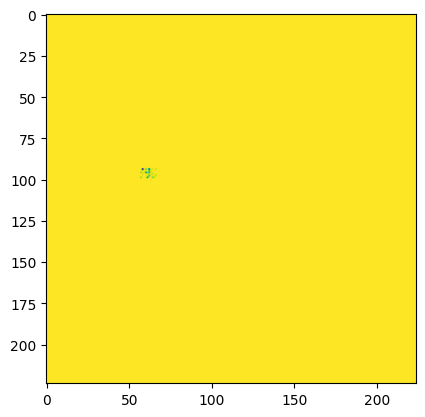

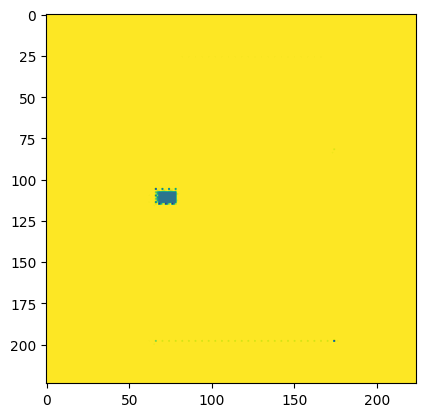

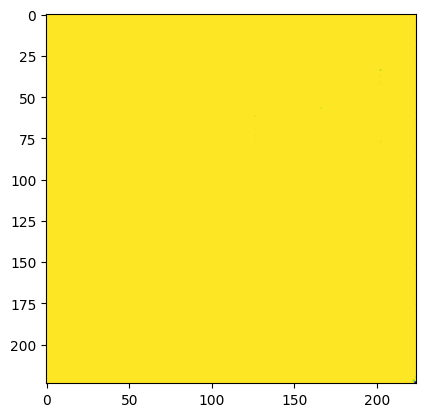

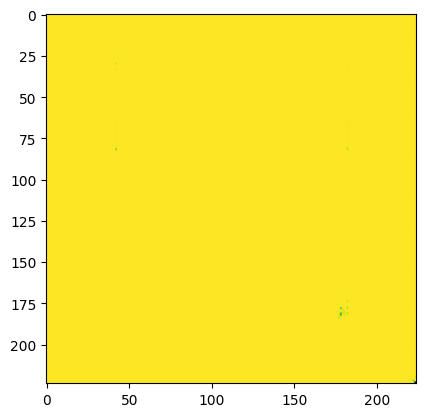

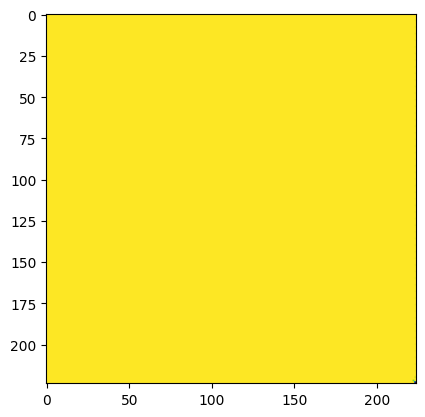

In [ ]:
from models import autoEncoder
auto_encoder = autoEncoder(train2_images)
for i in range(5):
  decoded = auto_encoder.call(np.expand_dims(train2_images[i], axis=0))
  plt.imshow(tf.squeeze(decoded))
  plt.show()
  

Setting CPU
10/10 [==============================] - 4s 332ms/step
Saving Model...
6/6 [==============================] - 2s 362ms/step


/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-04-25 12:07:27.639628', 'R2': 0.7234019667198044, 'MAE': 951152.1764357918, 'Percentage Error': 21.764159473436326, 'MSE': 1794277597016.5867, 'Feature Importances': {'image_predictions': 0.019094794228092696, 'reconstruction_error': 0.06447312346937091, 'postal_code': 0.0345033158038583, 'type': 0.0, 'size': 0.714999962194773, 'basement_size': 0.0, 'rooms': 0.014585185114543958, 'year_built': 0.02816366115940668, 'year_rebuilt': 0.0248616973283926, 'energy_label': 0.01083164680094412, 'lat': 0.011144471316838782, 'lng': 0.01453563087467069, 'postal_avg_sqm_price': 0.06280651170910828}}

Median Evaluation:
{'R2': 0.7591853087524807, 'MAE': 933187.0526637242, 'Percentage Error': 22.315677209808786, 'MSE': 1614270482428.5112}
Feauter Importance...
{'image_predictions': 0.019094794228092696, 'reconstruction_error': 0.06447312346937091, 'postal_code': 0.0345033158038583, 'type': 0.0, 'size': 0.714999962194773, 'basement_size': 0.0,

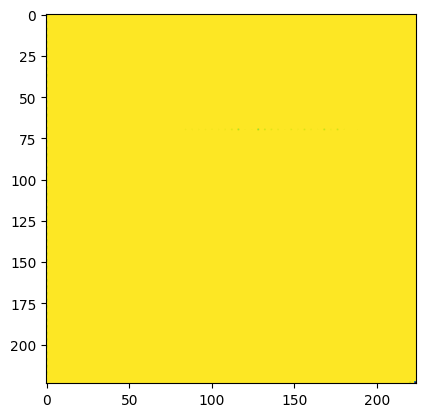

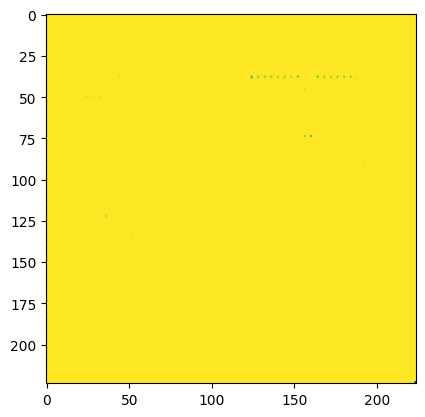

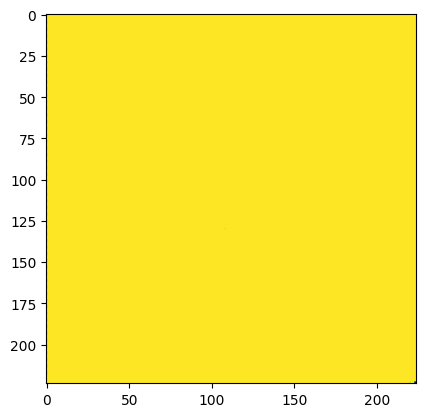

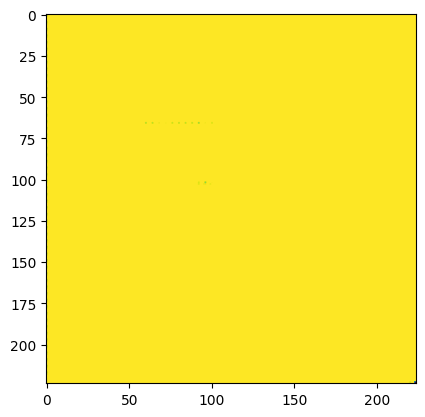

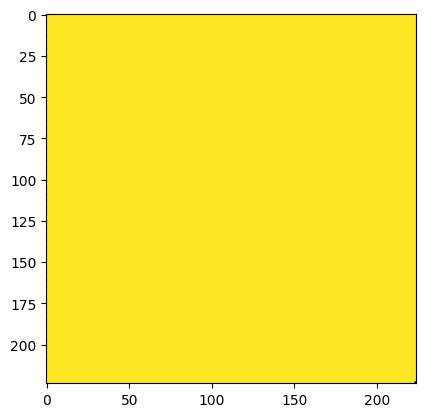

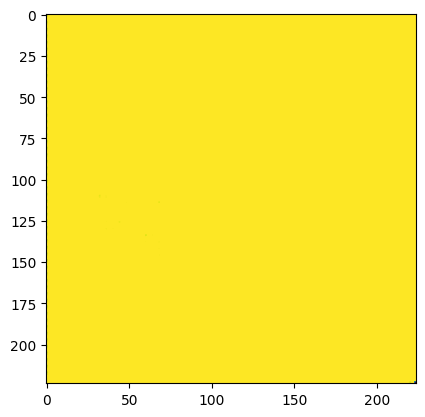

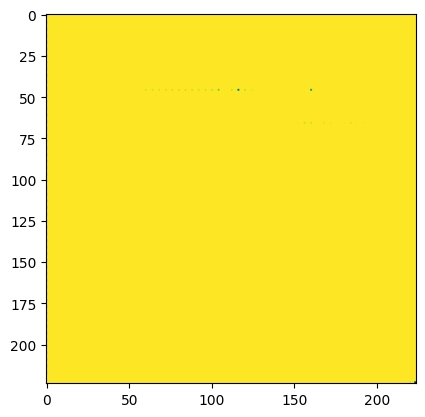

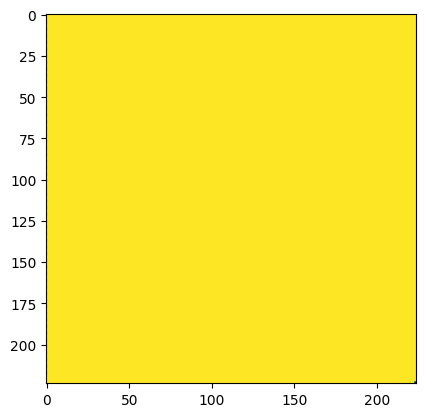

In [ ]:
from models import CNN_AE_RF_model
#img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
TYPE = 'CNN_AE_RF'
MODEL_NAME: str = "MobileNetV2_AE_RF"
FUNCTION: object = CNN_AE_RF_model
ARGS: tuple = (
    img_model, #keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    auto_encoder, #Or none for training it from scratch
    train2_images,
    train2_features,
    train2_prices,
)
train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

### N-CNN

In [ ]:
from models import N_CNN_RF_model
from keras.applications import MobileNetV3Small
TYPE = 'CNN_RF'
MODEL_NAME: str = "N_CNN_MobileNetV2_RF"
FUNCTION: object = N_CNN_RF_model
ARGS: tuple = (
    4,
    MobileNetV3Small,
    np.concatenate((train1_images, train2_images), axis=0),
    pd.concat((train1_features, train2_features), axis=0),

    np.concatenate((train1_prices, train2_prices), axis=0),
)
train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU


Compiling Model
Fitting Model
Epoch 1/100
4/4 [==============================] - 26s 4s/step - loss: 4100177.0000 - mean_absolute_error: 4098541.7500 - val_loss: 3974675.0000 - val_mean_absolute_error: 3973844.5000
Epoch 2/100
4/4 [==============================] - 13s 4s/step - loss: 4097649.2500 - mean_absolute_error: 4096912.5000 - val_loss: 3970960.7500 - val_mean_absolute_error: 3970133.5000
Epoch 3/100
4/4 [==============================] - 13s 3s/step - loss: 4092029.0000 - mean_absolute_error: 4091102.2500 - val_loss: 3960168.2500 - val_mean_absolute_error: 3959062.2500
Epoch 4/100
4/4 [==============================] - 13s 4s/step - loss: 4076274.5000 - mean_absolute_error: 4075067.5000 - val_loss: 3932723.0000 - val_mean_absolute_error: 3931239.0000
Epoch 5/100
4/4 [==============================] - 15s 4s/step - loss: 4038510.5000 - mean_absolute_error: 4036842.0000 - val_loss: 3870072.7500 - val_mean_absolute_error: 3867960.5000
Epoch 6/100
4/4 [============================

Compiling Model
Fitting Model
Epoch 1/100
4/4 [==============================] - 34s 5s/step - loss: 3976304.5000 - mean_absolute_error: 3974670.7500 - val_loss: 4099196.2500 - val_mean_absolute_error: 4098403.2500
Epoch 2/100
4/4 [==============================] - 15s 4s/step - loss: 3974827.0000 - mean_absolute_error: 3974155.0000 - val_loss: 4097955.7500 - val_mean_absolute_error: 4097257.0000
Epoch 3/100
4/4 [==============================] - 16s 5s/step - loss: 3973210.0000 - mean_absolute_error: 3972459.7500 - val_loss: 4094795.2500 - val_mean_absolute_error: 4093989.0000
Epoch 4/100
4/4 [==============================] - 15s 4s/step - loss: 3968725.2500 - mean_absolute_error: 3967885.2500 - val_loss: 4087048.0000 - val_mean_absolute_error: 4086078.0000
Epoch 5/100
4/4 [==============================] - 15s 4s/step - loss: 3958400.2500 - mean_absolute_error: 3957320.0000 - val_loss: 4069958.7500 - val_mean_absolute_error: 4068606.2500
Epoch 6/100
4/4 [============================

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
